In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
import os

In [2]:
%cd ..

/home/ltorres/leo/Cloud-Classification/cloud_classification


In [3]:
from src import utils
from src import dataset
from src.modules.graph_modules import GraphClassifier

In [4]:
import time
from sklearn.manifold import TSNE

In [5]:
torch.manual_seed(7)
np.random.seed(7)
random.seed(7)

In [6]:
%load_ext autoreload
%autoreload 2

#### functions

In [7]:
def stratified_sample(df, n=2, col='target', random_state = 7):
    
    paths = list()
    
    for key, sub_df in df.groupby(col):
        paths+= sub_df.sample(n=n, random_state=random_state)['path'].tolist()
        
    return paths

In [8]:
def random_sample(df, n=10, random_state = 7):

    paths = df.sample(n=n, random_state=random_state)['path'].tolist()
        
    return paths

In [9]:
def get_targets(paths):
        return list(map(int,list(map(int,[os.path.basename(x).split('_')[0] 
                                          for x in paths]))))

In [10]:
def get_vector_tokens(paths, model, device):
    data = dataset.GCD(paths, resize=256, use_augmentation=False)
    loader = utils.build_data_loader(data, batch_size=32)
    model.eval()
    
    outputs = list()
    
    for batch in loader:
        with torch.no_grad():
            deep_features = model.get_deep_features(batch['images'].to(device)).cpu()
            outputs.append(deep_features)
            
    return torch.cat(outputs, dim=0)
    

---

In [11]:
DATA_DIR = '/data/ltorres'
MODEL_DIR = '/data/ltorres/CLOUD_CLASSIFICATION_WEIGHTS'

SAVE_DIR = 'pivot_nodes'

In [12]:
device = "cuda:2"

#### load model

In [13]:
model_path = os.path.join(MODEL_DIR,'wandb_1353k0xc_model.pt')

In [15]:
model = GraphClassifier(
                 hidden_dim = 512, 
                 num_hidden = 2, 
                 num_classes = 7,
                 feature_extraction = False,
                 conv_type = 'gcn',
                 conv_parameters = {"num_heads":2, "agg":"sum"},
                 gnn_dropout = 0.3,
                 adjacency_builder = 'pearson_corr',
                 builder_parameter = 0.7,
                 use_both_heads = False,
                )

model.load_state_dict(torch.load(model_path))
model = model.to(device);

---

# Muestreo de imagenes para construccion del grafo

In [16]:
train_paths = utils.get_gcd_paths(DATA_DIR,'train')
train_targets = get_targets(train_paths)

df_train = pd.DataFrame({'path':train_paths, 'target':train_targets})

In [17]:
df_train['class'] = df_train['path'].apply(lambda x: x.split('/')[5].split('_')[-1])

## Random sample

In [18]:
train_paths = random_sample(df_train, 31)

In [19]:
pivot_features = get_vector_tokens(train_paths, model, device=device)

In [20]:
pivot_features.shape

torch.Size([31, 2048])

In [21]:
torch.save(pivot_features, os.path.join(SAVE_DIR,'random_sample.pt'))

## Stratified sample

In [22]:
train_paths = stratified_sample(df_train, 4)

In [23]:
pivot_features = get_vector_tokens(train_paths, model, device=device)

In [24]:
pivot_features.shape

torch.Size([28, 2048])

In [25]:
torch.save(pivot_features, os.path.join(SAVE_DIR,'stratified_sample.pt'))

## Centroid sample

- Obtener vectores para todos los nodos
- Obtener centroide para cada clase
- Obtener los 4 vectores mas cercanos (dilation) por cada clase con respecto a su centroide

### Vectores para todos los nodos

In [26]:
data = dataset.GCD(df_train['path'].tolist(), resize=256, use_augmentation=False)
loader = utils.build_data_loader(data, batch_size=32)

features = []

model.eval()

for batch in loader:
    with torch.no_grad():
        features.append(model.get_deep_features(batch['images'].to(device)).cpu())

features = torch.cat(features, dim=0)

#### visualizacion

In [27]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features.numpy())

/home/ltorres/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ltorres/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.014s...
[t-SNE] Computed neighbors for 10000 samples in 1.812s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.426719
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.834785
[t-SNE] KL divergence after 300 iterations: 2.622264


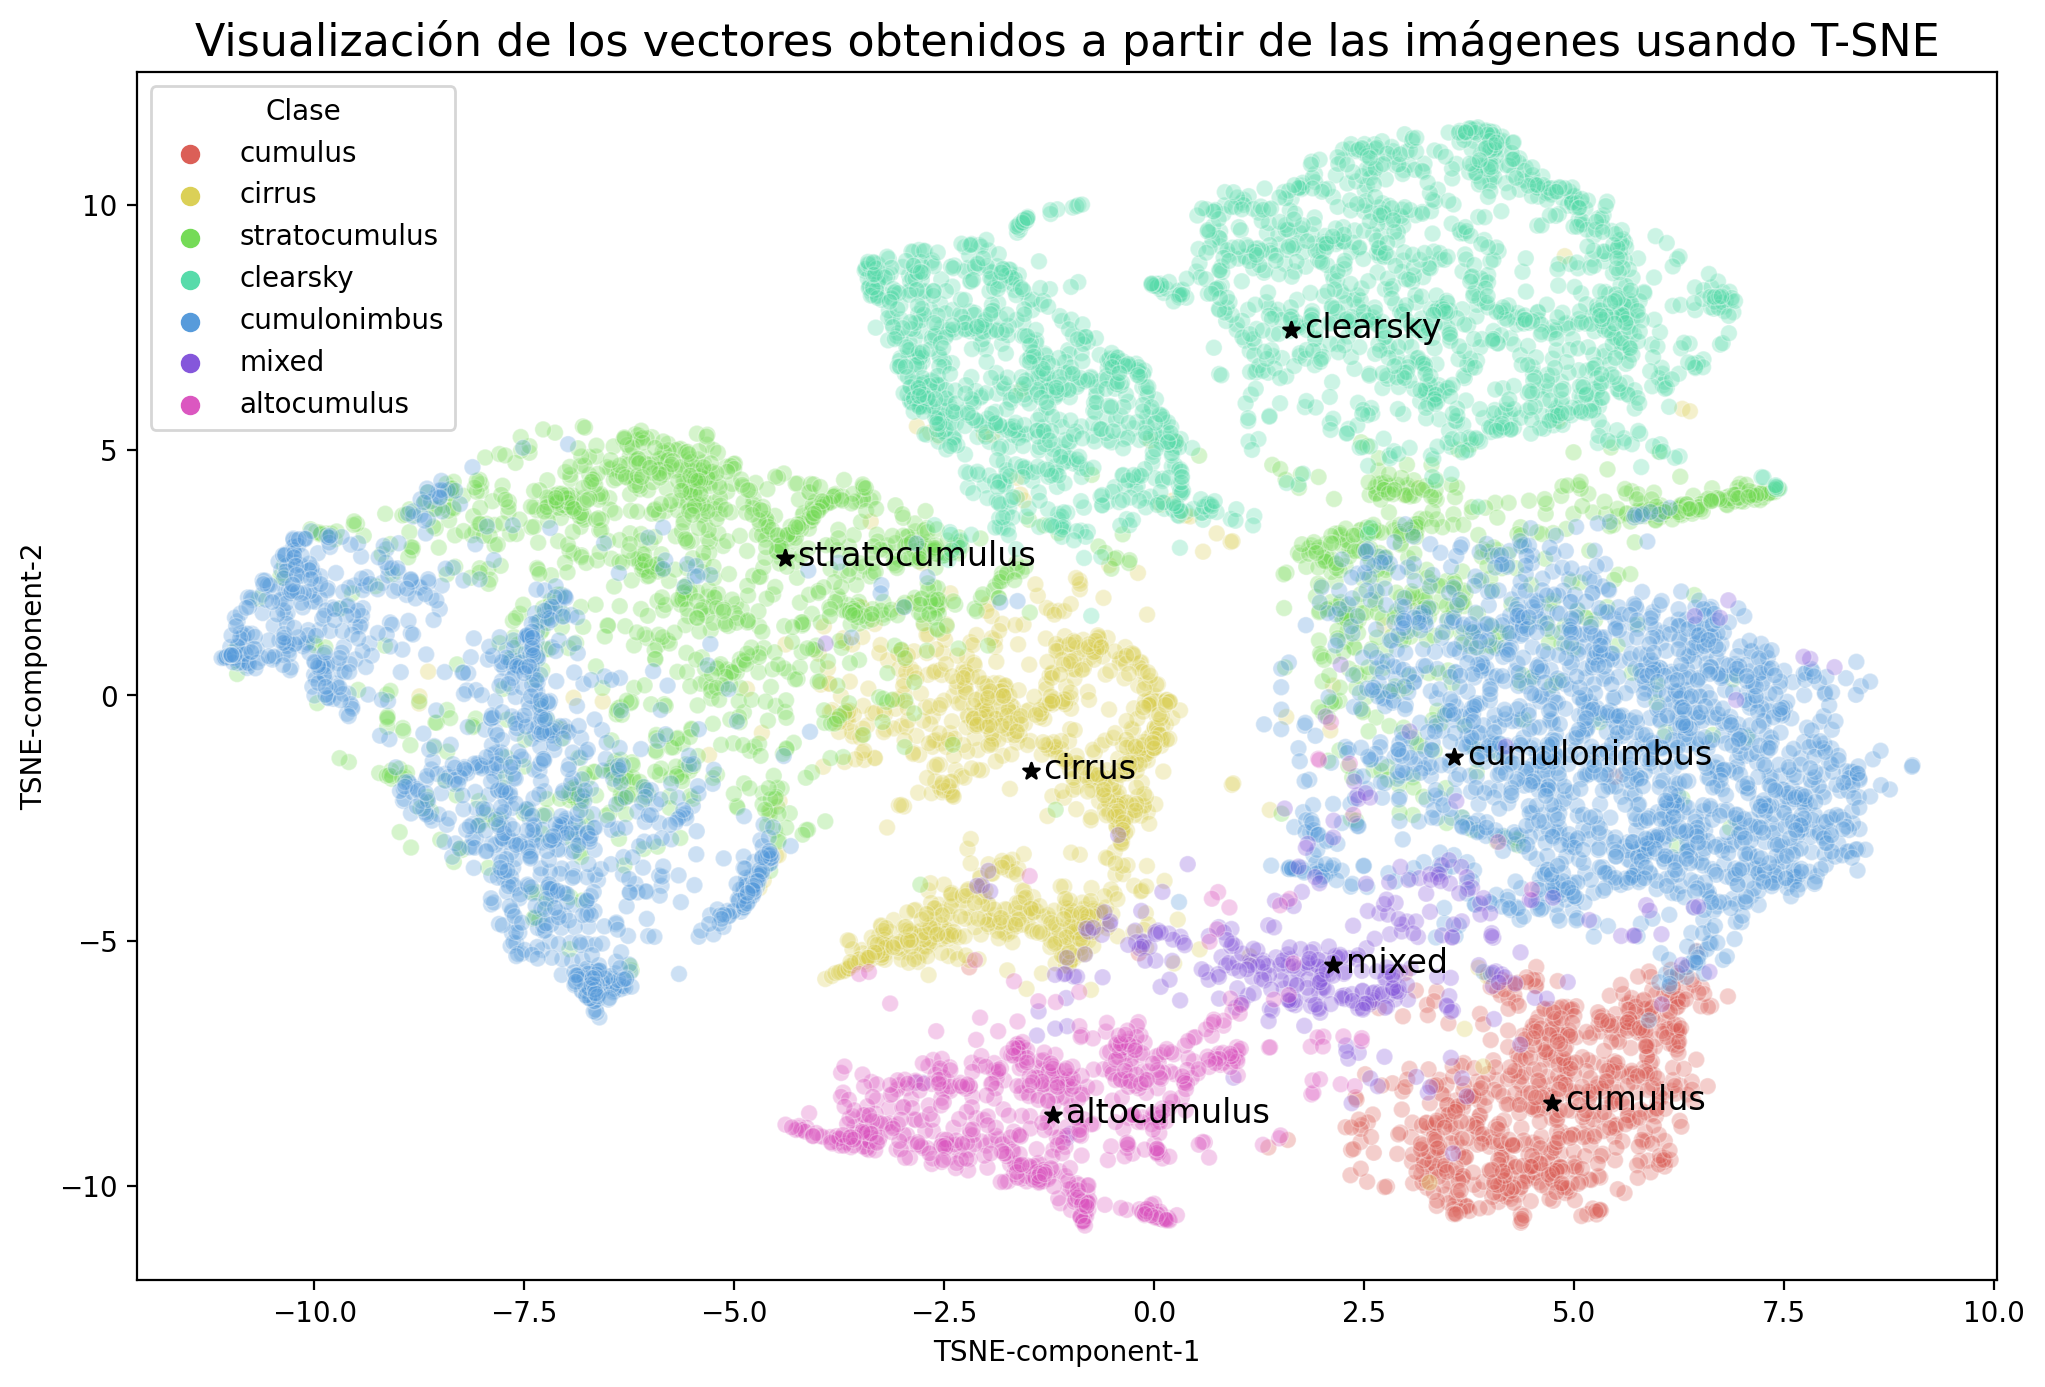

In [28]:
df_subset=pd.DataFrame()

df_subset['Clase'] = df_train['class'].values
df_subset['TSNE-component-1'] = tsne_results[:,0]
df_subset['TSNE-component-2'] = tsne_results[:,1]

### Grafico de embeddings

plt.figure(figsize=(12,8), dpi=200)
sns.scatterplot(
    x="TSNE-component-1", y="TSNE-component-2",
    hue="Clase",
    palette=sns.color_palette("hls", 7),
    data=df_subset,
    legend="full",
    alpha=0.3
)
plt.title('Visualización de los vectores obtenidos a partir de las imágenes usando T-SNE', fontsize=16)


### Centroides por clase
tsne_centroids = df_subset.groupby('Clase', as_index=False).median()
for index, row in tsne_centroids.iterrows():
    plt.scatter(row["TSNE-component-1"], row["TSNE-component-2"], c='black', marker='*')
    plt.annotate(row['Clase'], (row["TSNE-component-1"]+0.15, row["TSNE-component-2"]-0.15), fontsize=12)

plt.show()

### Centroides por clase

In [29]:
centroids = dict()

index_range = df_train.index.to_series().groupby(df_train['target']).agg(['first','last']).reset_index()

for index, row in index_range.iterrows():
    start_idx = row['first']
    end_idx = row['last']
    
    #print(start_idx, end_idx)
    centroids[index] = features[start_idx:end_idx+1, :].median(dim=0).values

In [30]:
torch.save(centroids, os.path.join(SAVE_DIR,'centroids.pt'))

### Distancia al centroide 

In [31]:
K=4

In [32]:
centroid_samples = list()

for index, row in index_range.iterrows():
    start_idx = row['first']
    end_idx = row['last']
    
    vectors = features[start_idx:end_idx+1, :]
    
    n_elements = vectors.shape[0]
    centroid = centroids[index].repeat(n_elements,1)
    
    distances = (vectors - centroid).pow(2).sum(-1).sqrt()
    dist, src_idx = torch.topk(-distances, k=K)
    
    centroid_samples.append(vectors[src_idx])
    
centroid_samples = torch.cat(centroid_samples, 0)

In [33]:
centroid_samples.shape

torch.Size([28, 2048])

In [34]:
torch.save(centroid_samples, os.path.join(SAVE_DIR,'centroid_sample.pt'))